# English Premier League Analysis
## From this analysis I would like to know:
> - What makes a team to get into top 4 in the league so that they are qualified to participate in Champions League?  
- Can we predict which teams are going to be in top4 based on team's statistics?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import matplotlib.patches as mpatches
import random
import warnings
import platform
import time
import re

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import naive_bayes
from sklearn import preprocessing


%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# load dataset
if platform.system() == 'Windows':
    tables = pd.read_csv('tables_crawler/tables_crawler/spiders/tables.csv')
    clubstats = pd.read_csv('clubstats_crawler/clubstats_crawler/spiders/clubstats.csv')
else:
    tables = pd.read_csv('data/tables.csv')
    clubstats = pd.read_csv('data/clubstats.csv')

In [3]:
tables.shape

(566, 8)

In [4]:
clubstats.shape

(566, 15)

In [5]:
tables.head()

,club_name,drawn,goal,goal_against,lost,points,position,won
0,Liverpool,1,66,21,1,82,1,27
1,Manchester City,3,68,31,7,57,2,18
2,Leicester City,5,58,28,8,53,3,16
3,Chelsea,6,51,39,9,48,4,14
4,Manchester United,9,44,30,8,45,5,12


In [6]:
clubstats.head()

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,season,shooting_accuracy,shot_on_target,tackle_success
0,"1,853",38,519,Arsenal,548,22%,1.29,1.43,258,84%,507.11,2019/20,35%,109,58%
1,"2,489",72,762,Arsenal,605,21%,1.34,1.92,412,83%,547.50,2018/19,36%,170,60%
2,"2,660",81,829,Arsenal,572,21%,1.34,1.95,427,84%,619.05,2017/18,39%,234,68%
3,"2,762",55,838,Arsenal,697,22%,1.16,2.03,536,84%,563.00,2016/17,36%,201,70%
4,"2,785",88,849,Arsenal,754,25%,0.95,1.71,734,84%,559.18,2015/16,37%,211,73%


**Total rows: 566, Total cols: 23**

## Data Preprocessing
> - Change into proper data types  
- Handling NA values

In [7]:
tables.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   club_name     566 non-null    object
 1   drawn         566 non-null    int64 
 2   goal          566 non-null    int64 
 3   goal_against  566 non-null    int64 
 4   lost          566 non-null    int64 
 5   points        566 non-null    int64 
 6   position      566 non-null    int64 
 7   won           566 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 35.5+ KB


### 'tables' is already in proper data types. Also no NA values.

In [8]:
clubstats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   aerial_battles           566 non-null    object 
 1   big_chance_created       566 non-null    int64  
 2   clearance                566 non-null    object 
 3   club_name                566 non-null    object 
 4   cross                    566 non-null    object 
 5   cross_accuracy           566 non-null    object 
 6   goal_conceded_per_match  566 non-null    float64
 7   goal_per_match           566 non-null    float64
 8   interceptions            566 non-null    int64  
 9   pass_accuracy            566 non-null    object 
 10  pass_per_game            566 non-null    float64
 11  season                   566 non-null    object 
 12  shooting_accuracy        566 non-null    object 
 13  shot_on_target           566 non-null    int64  
 14  tackle_success           5

In [9]:
# Change to proper data types
clubstats['cross_accuracy'] = clubstats['cross_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['pass_accuracy'] = clubstats['pass_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['shooting_accuracy'] = clubstats['shooting_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['tackle_success'] = clubstats['tackle_success'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['aerial_battles'] = clubstats['aerial_battles'].str.replace(',','').astype('int')
clubstats['clearance'] = clubstats['clearance'].str.replace(',','').astype('int')
clubstats['cross'] = clubstats['cross'].str.replace(',','').astype('int')

# In 'clubstats' AFC Bournemouth is named as it is, but in 'tables' it is named as 'Bournemouth'.
# So in order to join the two data frames, the club_name for AFC Bournmouth has to be changed.
clubstats['club_name'][53] = 'Bournemouth'
clubstats['club_name'][54] = 'Bournemouth'
clubstats['club_name'][55] = 'Bournemouth'
clubstats['club_name'][56] = 'Bournemouth'
clubstats['club_name'][57] = 'Bournemouth'

### Need to join two tables, but there is no column that indicate what season it is on 'tables'.  Data were scraped descending order, which is 2019 to 1992, we just need to add the information on 'tables'.

In [10]:
season_info = clubstats[clubstats['club_name'] == "Arsenal"]['season']
seasons = []

for i in range(len(season_info)):
    if i < 25:
        seasons.append([season_info[i],] * 20)
    else:
        seasons.append([season_info[i],] * 22)

seasons_flat = [season for sub_season in seasons for season in sub_season]
tables['season'] = seasons_flat

# Join two data frames
data = pd.merge(tables, clubstats, on=['club_name', 'season'])

# To get total number of games
data['total_games'] = data['won'] + data['drawn'] + data['lost']
# Add top4 indicator 
data['is_top4'] = data['position'].apply(lambda x: 1 if (x <= 4) else 0)

In [11]:
data.head()

,club_name,drawn,goal,goal_against,lost,points,position,won,season,aerial_battles,...,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success,total_games,is_top4
0,Liverpool,1,66,21,1,82,1,27,2019/20,1982,...,0.72,2.28,267,84,622.17,39,176,60,29,1
1,Manchester City,3,68,31,7,57,2,18,2019/20,1747,...,1.11,2.43,263,89,675.89,35,192,58,28,1
2,Leicester City,5,58,28,8,53,3,16,2019/20,2183,...,1.03,2.00,330,82,516.31,38,154,58,29,1
3,Chelsea,6,51,39,9,48,4,14,2019/20,2265,...,1.34,1.76,363,85,602.00,35,169,56,29,1
4,Manchester United,9,44,30,8,45,5,12,2019/20,2018,...,1.03,1.52,286,82,503.31,39,166,57,29,0


In [12]:
# Since I want to predict top4 for this season, I will exclude this season (train ans test set)
current_season = data[data['season'] == '2019/20']
past_seasons = data[data['season'] != '2019/20'].reset_index(drop=True)

## Exploratory Data Analysis 

In [13]:
# Visual parameters
t4_color = '#3d195b'
b4_color = '#c9d6df'
b_color = '#f7f7f7'
seaborn_color = [b4_color, t4_color]
sns.set_palette(sns.color_palette(seaborn_color))
t4_legend = mpatches.Patch(color=t4_color, label='Top 4', edgecolor='black')
b4_legend = mpatches.Patch(color=b4_color, label='Below 4', edgecolor='black')

In [14]:
top4 = past_seasons[past_seasons['is_top4'] == 1]
below4 = past_seasons[past_seasons['is_top4'] == 0]

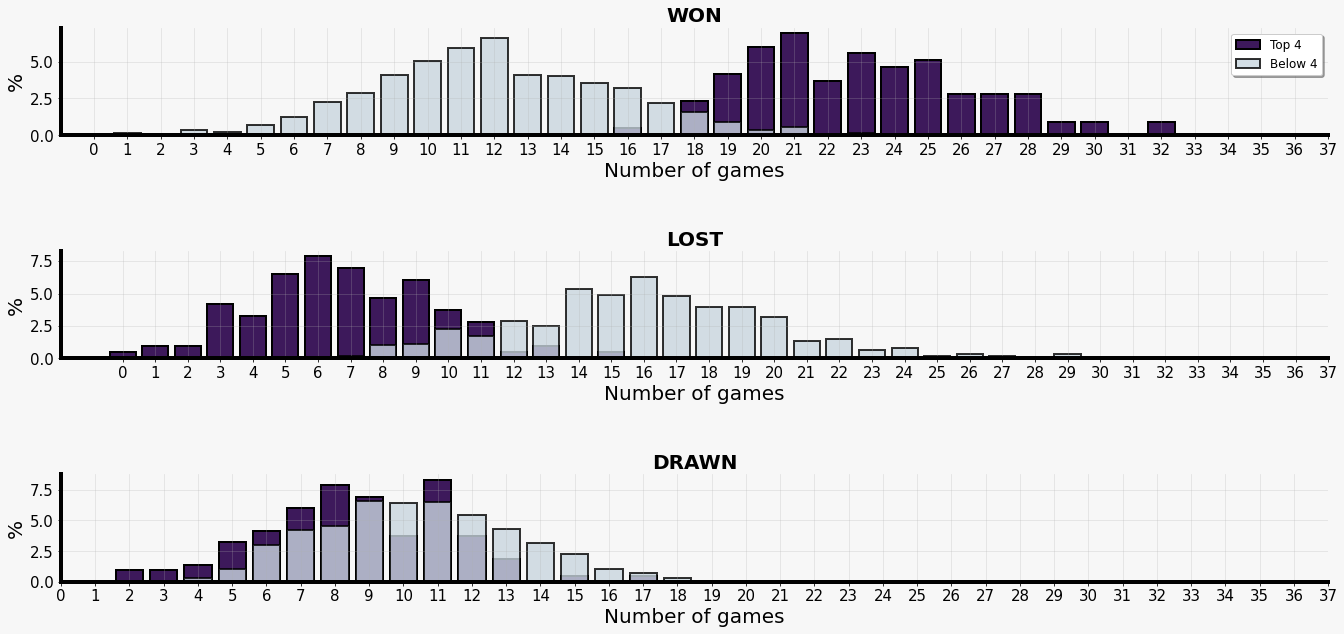

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(20,10))
cols = ['won', 'lost', 'drawn']

for i, col in enumerate(cols):
    t4_index = top4[col].value_counts().index
    t4_values = top4[col].value_counts().values
    b4_index = below4[col].value_counts().index
    b4_values = below4[col].value_counts().values
    
    ax.flatten()[i].bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='black', alpha=1, linewidth=2, label='Top 4')
    ax.flatten()[i].bar(x=b4_index, height=b4_values/4.38, color=b4_color, edgecolor='black', alpha=0.8, linewidth=2, label='Below 4')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticks(np.arange(0, 38, 1))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)
    ax.flatten()[i].set_xlabel('Number of games', fontsize=20)
    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
    ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
        
    

fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

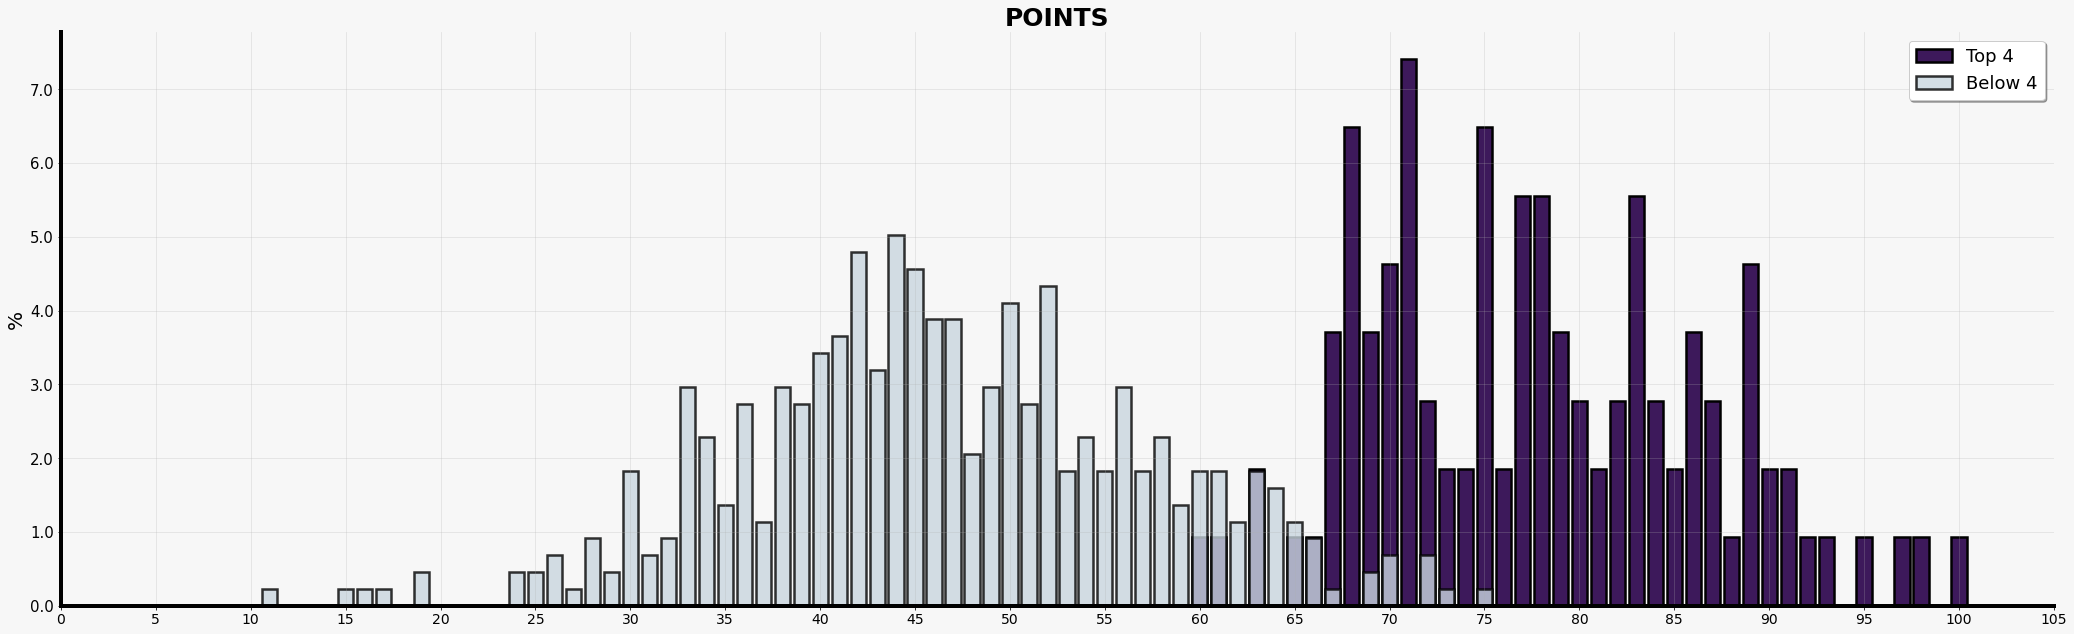

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
col = 'points'

t4_index = top4[col].value_counts().index
t4_values = top4[col].value_counts().values
b4_index = below4[col].value_counts().index
b4_values = below4[col].value_counts().values

ax.bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='black', alpha=1, linewidth=2.5, label='Top 4')
ax.bar(x=b4_index, height=b4_values/4.38, color=b4_color, edgecolor='black', alpha=0.8, linewidth=2.5, label='Below 4')

ax.grid(which='major', axis='x', zorder=0, alpha=0.3)
ax.grid(which='major', axis='y', zorder=0, alpha=0.3)

ax.set_xticks(np.arange(0, 110, 5))
ax.set_title(col.upper(), weight='bold', fontsize=25)
ax.set_ylabel('%', fontsize=20)
ax.set_xticklabels(ax.get_xticks(), fontsize=20)
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_facecolor(b_color)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)

ax.legend(loc=1, shadow=True, fontsize=18)

fig.set_facecolor(b_color)
fig.tight_layout(pad=5)
plt.show()

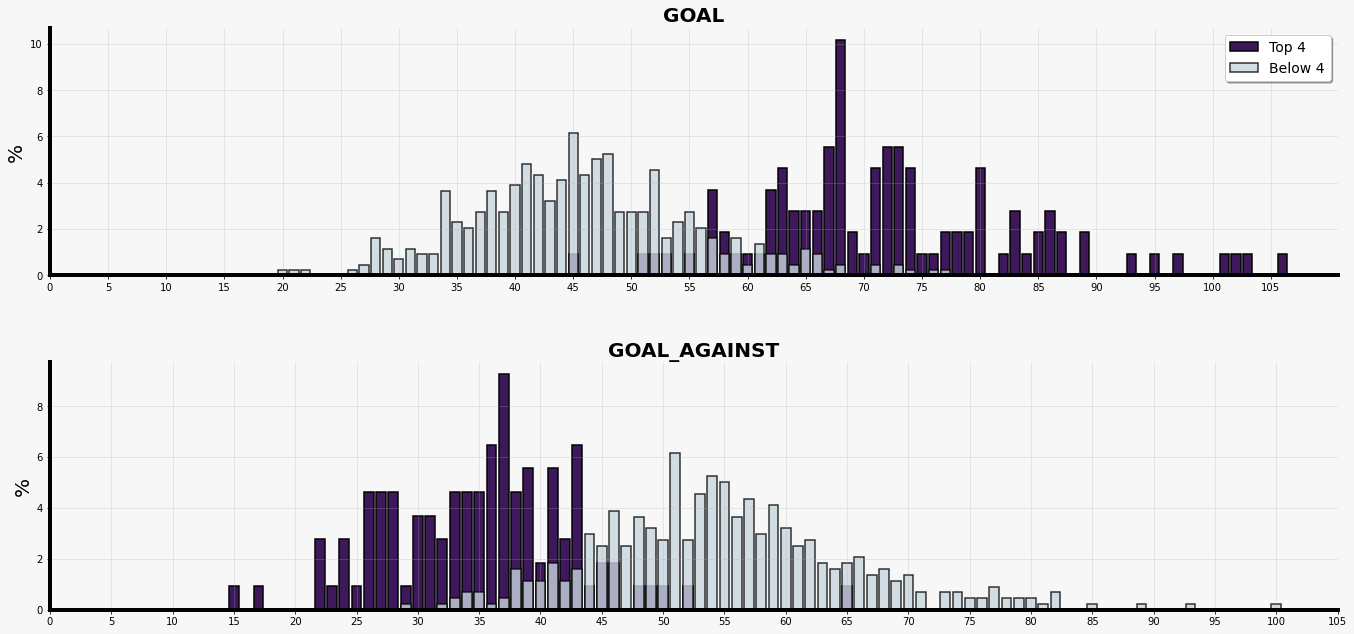

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))
cols = ['goal', 'goal_against']

for i, col in enumerate(cols):
    t4_index = top4[col].value_counts().index
    t4_values = top4[col].value_counts().values
    b4_index = below4[col].value_counts().index
    b4_values = below4[col].value_counts().values
    
    ax.flatten()[i].bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='black', alpha=1, linewidth=1.5, label='Top 4')
    ax.flatten()[i].bar(x=b4_index, height=b4_values/4.38, color=b4_color, edgecolor='black', alpha=0.8, linewidth=1.5, label='Below 4')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticks(np.arange(0, 110, 5))
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=14)

fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

In [18]:
seasons = np.flip(data['season'].unique())

t4_legend = mpatches.Patch(color=t4_color, label='Top 4', edgecolor='black')
b4_legend = mpatches.Patch(color=b4_color, label='Below 4', edgecolor='black')

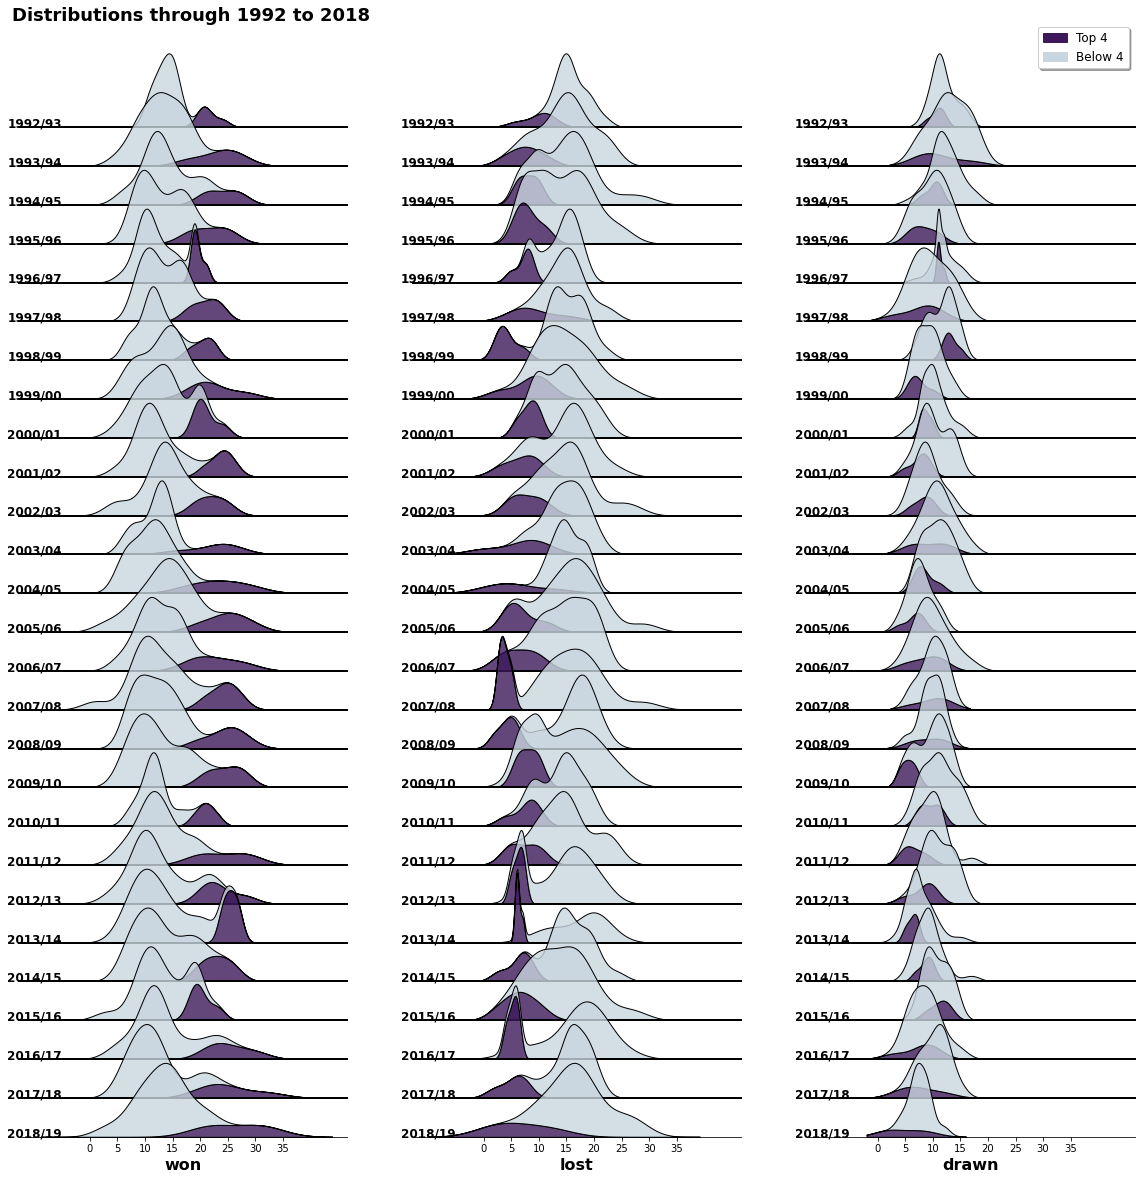

In [19]:
cols = ['won', 'lost', 'drawn']

fig, ax = plt.subplots(len(seasons[:-1]), 3, figsize=(20, 20), 
                       sharex=True, gridspec_kw={'hspace':-0.5}, tight_layout=True)

for i, col in enumerate(cols):
    for j, season in enumerate(seasons[:-1]):
        sns.kdeplot(data=data[data['season'] == season], x=col, hue='is_top4',  alpha=.8, 
                    edgecolor='black', multiple='stack', legend=False, ax=ax[j, i])
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].grid(False)
        ax[j, i].get_yaxis().set_visible(False)
        ax[j, i].set_facecolor('None')

        if j != len(seasons[:-1])-1:
            ax[j, i].spines['bottom'].set_linewidth(2)
            ax[j, i].set_xticks(np.arange(0, 40, 5))
            ax[j, i].get_xaxis().set_visible(False)
            ax[j, i].text(-15, 0, season, fontweight='bold', fontsize=12)
        else:
            ax[j, i].get_xaxis().set_visible(True)
            ax[j, i].text(-15, 0, season, fontweight='bold', fontsize=12)
            ax[j, i].set_xlabel(col, fontsize=16, fontweight='bold')

fig.legend(bbox_to_anchor=(0.9, 0.9), handles=[t4_legend, b4_legend], shadow=True, fontsize=12)
fig.text(0.12, 0.9, 'Distributions through 1992 to 2018', fontsize=18, fontweight='bold')     
plt.show()

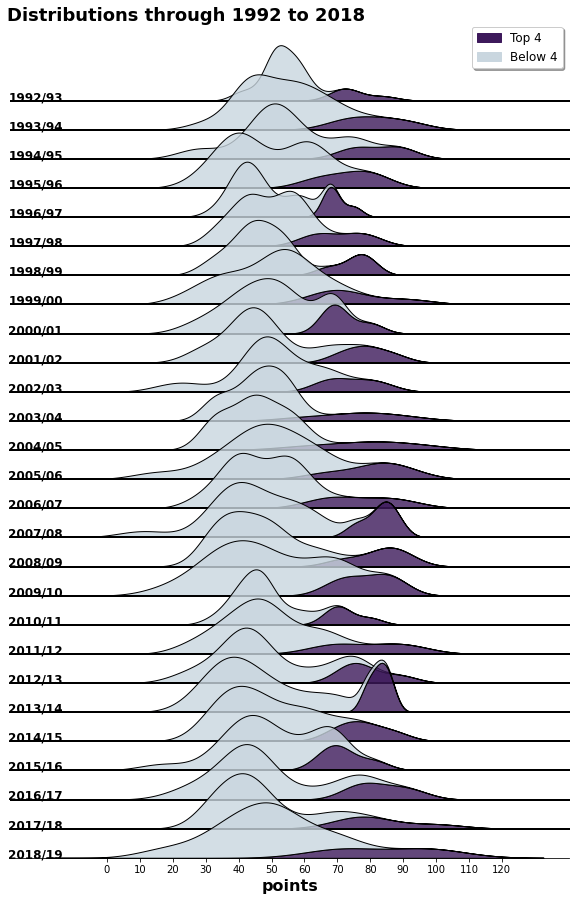

In [20]:
fig, ax = plt.subplots(len(seasons[:-1]), 1, figsize=(10, 15), 
                       sharex=True, gridspec_kw={'hspace':-0.5}, tight_layout=True)

for j, season in enumerate(seasons[:-1]):
    sns.kdeplot(data=data[data['season'] == season], x='points', hue='is_top4',  alpha=.8, 
                edgecolor='black', multiple='stack', legend=False, ax=ax[j])
    
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    ax[j].grid(False)
    ax[j].get_yaxis().set_visible(False)
    ax[j].set_facecolor('None')
    
    if j != len(seasons[:-1])-1:
        ax[j].spines['bottom'].set_linewidth(2)
        ax[j].get_xaxis().set_visible(False)
        ax[j].set_xticks(np.arange(0,130,10))
        ax[j].text(-30, 0, season, fontweight='bold', fontsize=12)
    else:
        ax[j].get_xaxis().set_visible(True)
        ax[j].set_xticks(np.arange(0,130,10))
        ax[j].set_xlabel('points', fontsize=16, fontweight='bold')
        ax[j].text(-30, 0, season, fontweight='bold', fontsize=12)

fig.legend(bbox_to_anchor=(0.9, 0.9), handles=[t4_legend, b4_legend], shadow=True, fontsize=12)
fig.text(0.12, 0.9, 'Distributions through 1992 to 2018', fontsize=18, fontweight='bold')     
plt.show()

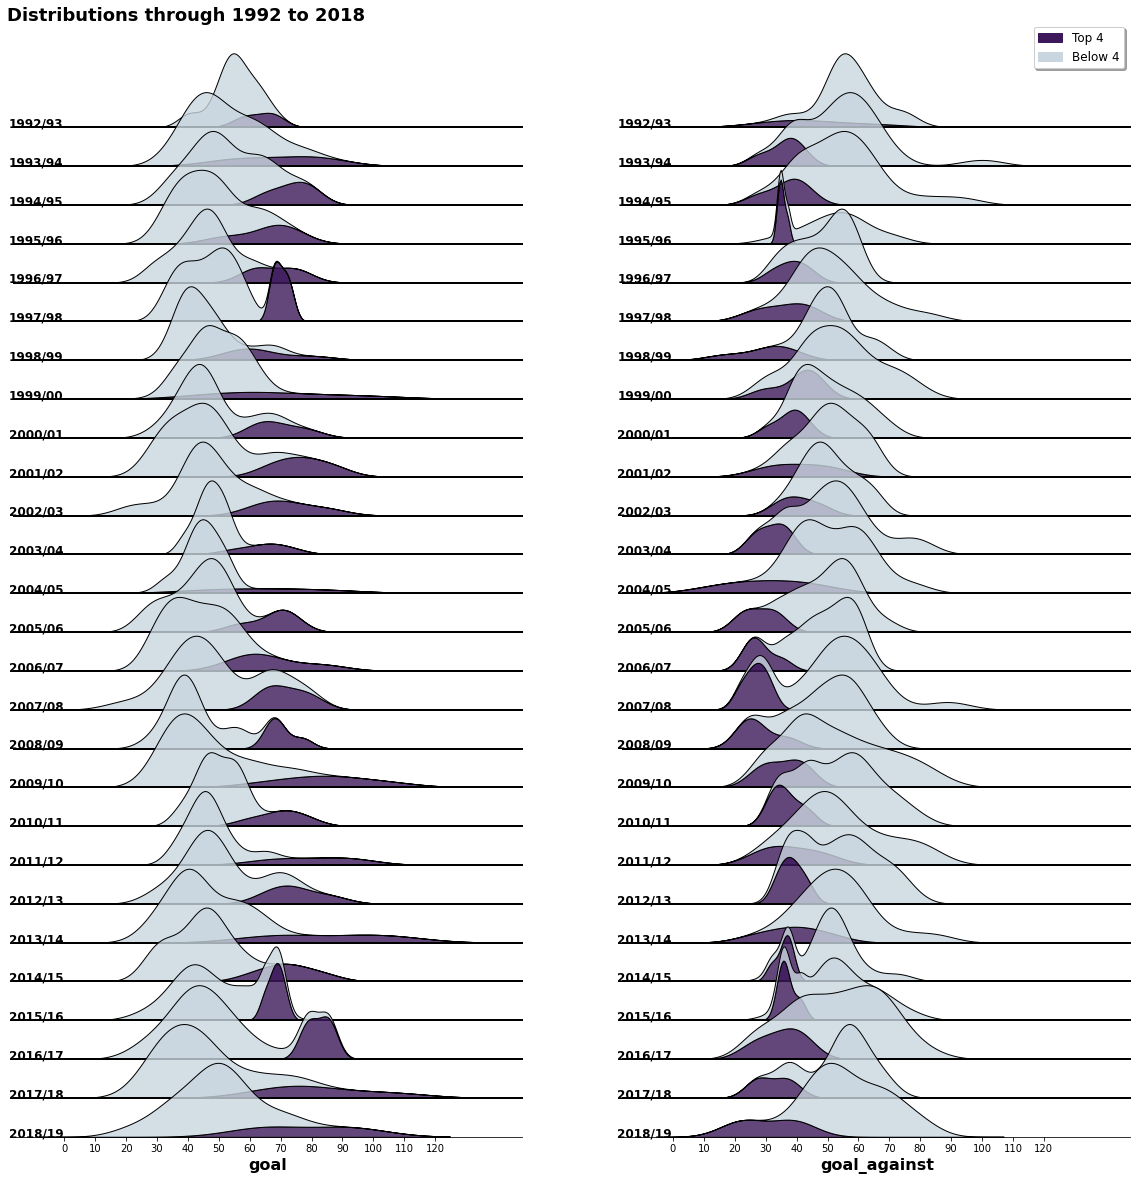

In [21]:
cols = ['goal', 'goal_against']

fig, ax = plt.subplots(len(seasons[:-1]), 2, figsize=(20, 20), 
                       sharex=True, gridspec_kw={'hspace':-0.5}, tight_layout=True)

for i, col in enumerate(cols):
    for j, season in enumerate(seasons[:-1]):
        sns.kdeplot(data=data[data['season'] == season], x=col, hue='is_top4',  alpha=.8, 
                    edgecolor='black', multiple='stack', legend=False, ax=ax[j, i])
        
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].grid(False)
        ax[j, i].get_yaxis().set_visible(False)
        ax[j, i].set_facecolor('None')

        if j != len(seasons[:-1])-1:
            ax[j, i].spines['bottom'].set_linewidth(2)
            ax[j, i].get_xaxis().set_visible(False)
            ax[j, i].text(-18, 0, season, fontweight='bold', fontsize=12)
        else:
            ax[j, i].get_xaxis().set_visible(True)
            ax[j, i].text(-18, 0, season, fontweight='bold', fontsize=12)
            ax[j, i].set_xlabel(col, fontsize=16, fontweight='bold')
            ax[j, i].set_xticks(np.arange(0,130,10))

fig.legend(bbox_to_anchor=(0.9, 0.9), handles=[t4_legend, b4_legend], shadow=True, fontsize=12)
fig.text(0.12, 0.9, 'Distributions through 1992 to 2018', fontsize=18, fontweight='bold')     
plt.show()

**It looks like there is no difference between past and current in term of how many win, lost, draw games are needed to be in the top 4.**

In [22]:
features = ['aerial_battles', 'big_chance_created', 'clearance', 'cross', 'cross_accuracy', 'goal_conceded_per_match', 
            'goal_per_match', 'interceptions', 'pass_accuracy', 'pass_per_game', 'shooting_accuracy', 'shot_on_target', 'tackle_success']

**The data before season 2006 have many features that are zero due to the reason as follows:**  
"When the Premier League began in 1992/93, only a basic level of match data was gathered. Over time this has increased and since 2006/07 a wide range of statistics are now provided. The information below shows a breakdown of the statistics on the Premier League website and the season this data originated." **from EPL offical website, https://www.premierleague.com/stats/clarification**

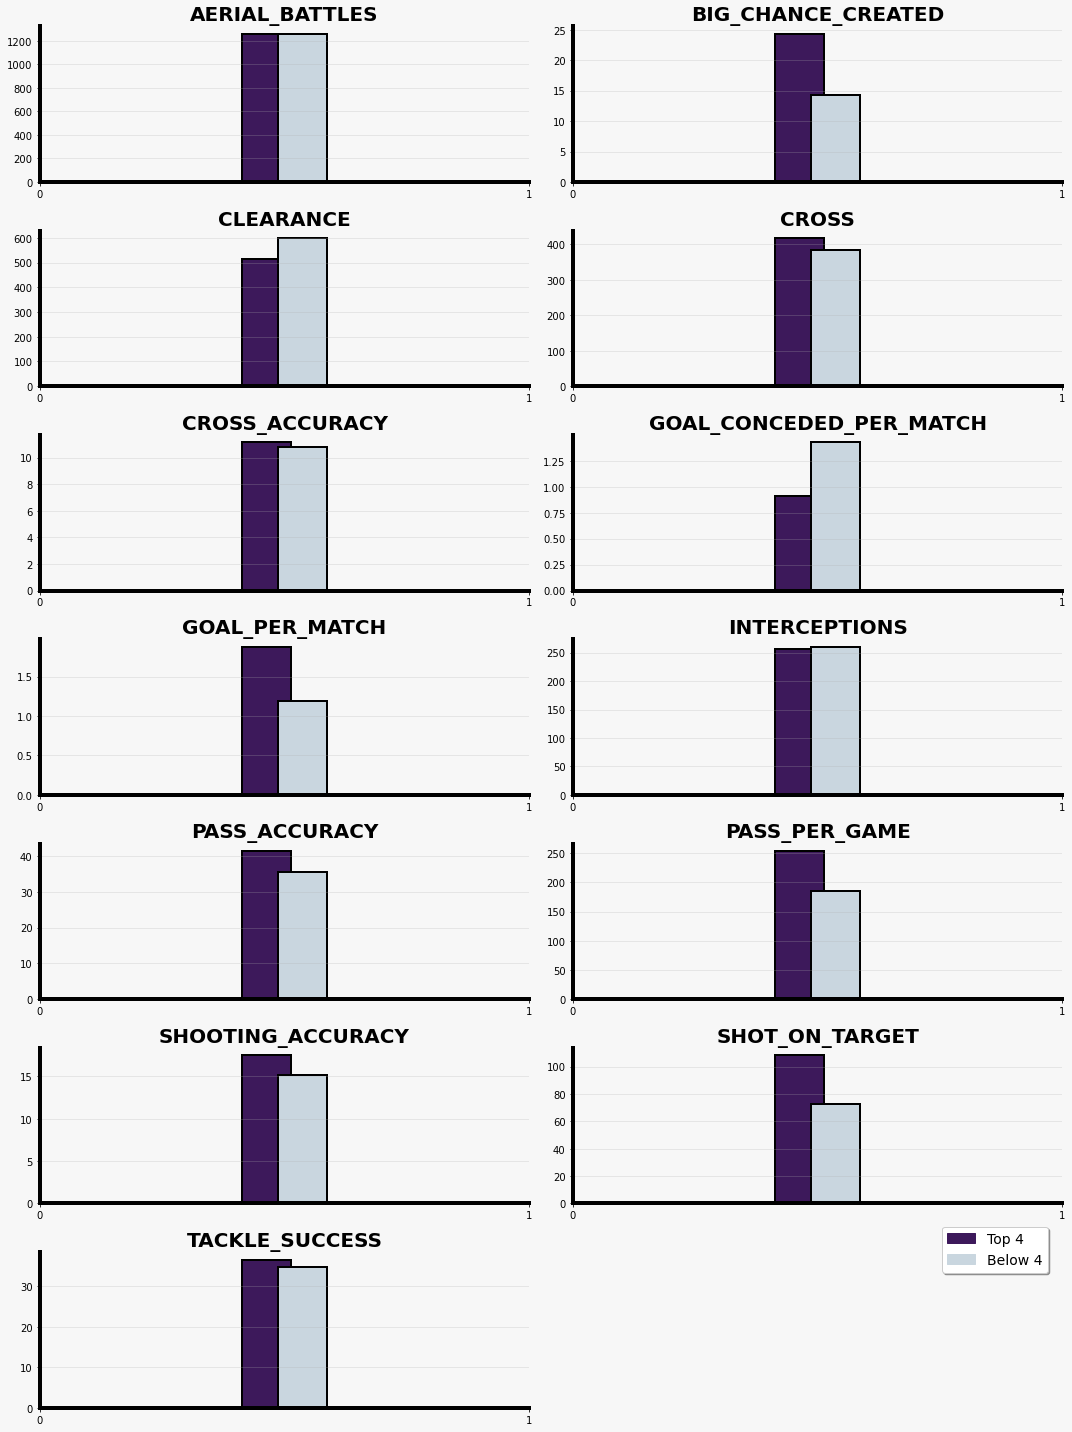

In [23]:
fig, ax = plt.subplots(7, 2, figsize=(15,20))
cols = features

for i, col in enumerate(cols):
    t4_index = top4[col].value_counts().index
    t4_values = np.mean(top4[col])
    b4_index = below4[col].value_counts().index
    b4_values = np.mean(below4[col])

    ax.flatten()[i].bar(x=0.5-0.075/2, height=t4_values, width=0.1, color=t4_color, edgecolor='black', linewidth=2)
    ax.flatten()[i].bar(x=0.5+0.075/2, height=b4_values, width=0.1, color=b4_color, edgecolor='black', linewidth=2)

    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)

    ax.flatten()[i].set_xticks(np.arange(0,2,1))
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
    ax.flatten()[i].set_facecolor(b_color)

    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)

ax.flatten()[-1].set_facecolor(b_color)
ax.flatten()[-1].grid(which='major', axis='x', zorder=0, color=b_color)
ax.flatten()[-1].grid(which='major', axis='y', zorder=0, color=b_color)
ax.flatten()[-1].spines['top'].set_visible(False)
ax.flatten()[-1].spines['right'].set_visible(False)
ax.flatten()[-1].spines['bottom'].set_linewidth(False)
ax.flatten()[-1].spines['left'].set_linewidth(False)
ax.flatten()[-1].get_xaxis().set_visible(False)
ax.flatten()[-1].get_yaxis().set_visible(False)

fig.set_facecolor(b_color)
fig.legend(bbox_to_anchor=(0.98, 0.15), handles=[t4_legend, b4_legend], shadow=True, fontsize=14)
fig.tight_layout()
plt.show()

**The significant different features between Top 4 and Below 4 clubs are 'big_chance_created', 'goal_conceded_per_match', 'goal_per_match', 'pass_per_game', and 'shot_on_target'**  
**In this plots, an interesting part is features that are significant different are kind of obvious features that related to win a match, but there are several features that**

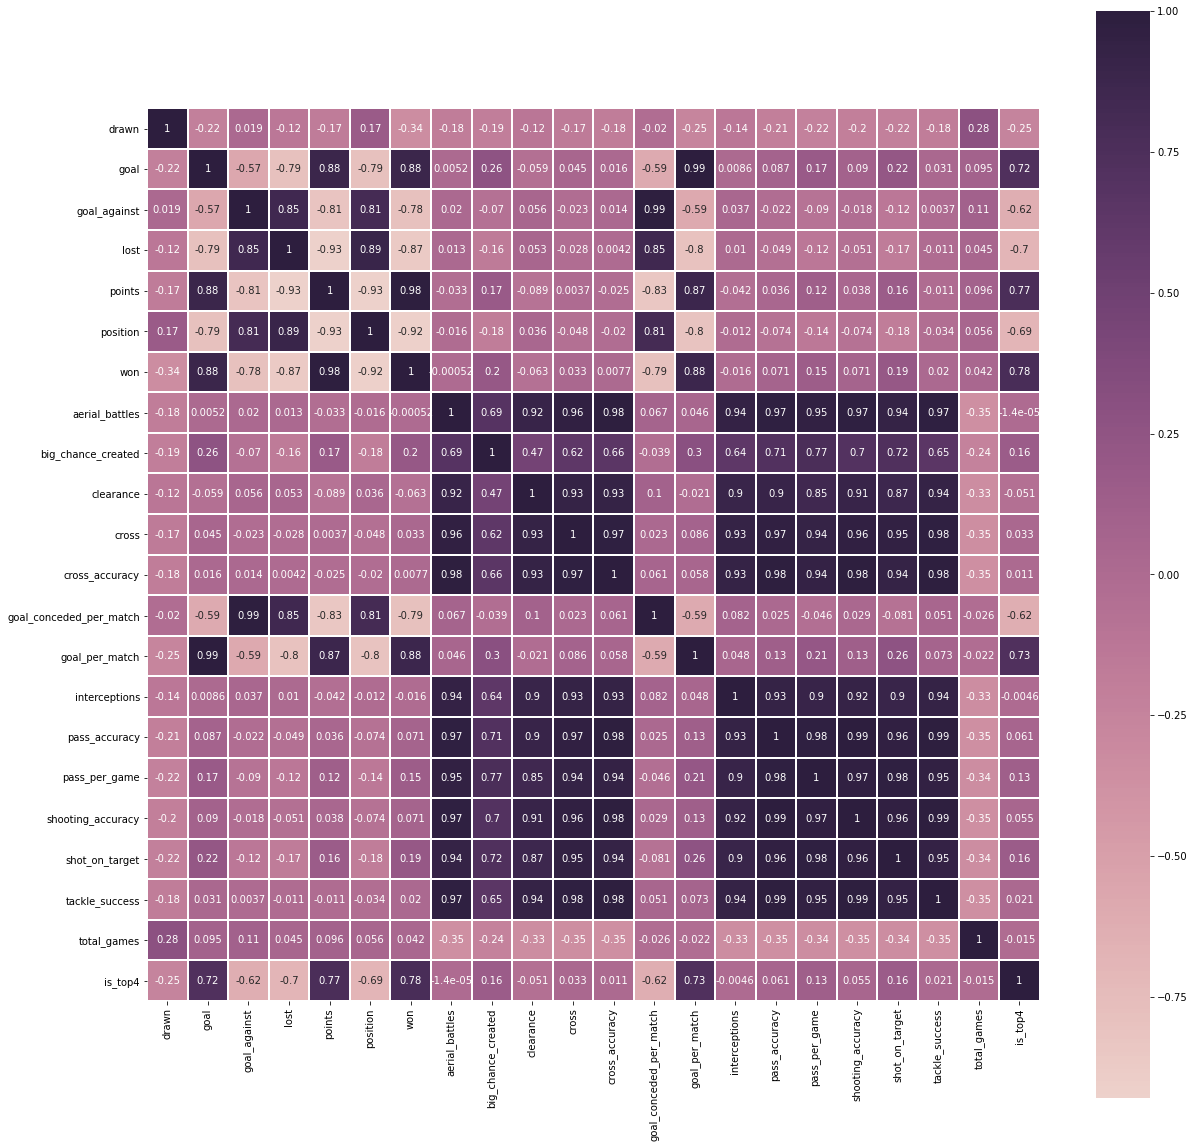

In [24]:
p_season_corr = past_seasons.corr()

plt.figure(figsize=(20,20))
sns.heatmap(p_season_corr, 
            mask=np.zeros_like(p_season_corr, dtype=np.bool), 
            annot=True, cmap=sns.cubehelix_palette(as_cmap=True), square=True, linewidths=0.1)
plt.show()

## ML

### Creating two models for tables and club statistics

In [25]:
t_cols = list(tables.columns)
t_cols.append('is_top4')

c_cols = list(clubstats.columns)
c_cols.append('is_top4')

tables_train = data[t_cols]
clubstats_train = data[c_cols]
tables_train = tables_train.drop('club_name', axis=1)
clubstats_train = clubstats_train.drop('club_name', axis=1)


pattern = re.compile('/\d*')

tables_train['season'] = tables_train['season'].apply(lambda x: pattern.sub('', x))
clubstats_train['season'] = clubstats_train['season'].apply(lambda x: pattern.sub('', x))

tables_train['season'] = tables_train['season'].astype(int)
clubstats_train['season'] = clubstats_train['season'].astype(int)

tables_test = tables_train[tables_train['season'] == 2019]
clubstats_test = clubstats_train[clubstats_train['season'] == 2019]

num_match = tables_test[['won', 'drawn', 'lost']].apply(np.sum, axis=1)

for i, n in enumerate(num_match):
    tables_test.loc[i,['drawn', 'goal', 'goal_against', 'lost', 'points', 'won']] /= n

    
tables_train = tables_train.drop(tables_test.index, axis=0)
clubstats_train = clubstats_train.drop(clubstats_test.index, axis=0)

tables_train.loc[:, ['drawn', 'goal', 'goal_against', 'lost', 'points', 'won']] /= 38

# Shuffle the dataset
tables_train = tables_train.sample(frac=1, random_state=2021)
clubstats_train = clubstats_train.sample(frac=1, random_state=2021)

#### Selected the periods that have non zero data for club statistics, which is from 2006/07 to 2019/20

clubstats_train = clubstats_train[clubstats_train['season'] > 2005]

### Create train, cv, and test set

In [29]:
# Split Train and Test set
X_club_train, X_club_test, y_club_train, y_club_test = train_test_split(clubstats_train.drop('is_top4', axis=1), clubstats_train['is_top4'], test_size=0.4, random_state=2021, stratify=clubstats_train['is_top4'])
X_table_train, X_table_test, y_table_train, y_table_test = train_test_split(tables_train.drop('is_top4', axis=1), tables_train['is_top4'], test_size=0.4, random_state=2021, stratify=tables_train['is_top4'])

# Split Test set for validation set
X_club_valid, X_club_test, y_club_valid, y_club_test = train_test_split(X_club_test, y_club_test, test_size=0.5, random_state=2021, stratify=y_club_test)
X_table_valid, X_table_test, y_table_valid, y_table_test = train_test_split(X_table_test, y_table_test, test_size=0.5, random_state=2021, stratify=y_table_test)

#### Baseline models with every feature
Need to think about why it better to use random forest and svm over xgboost?

1. Size of the training data
It is usually recommended to gather a good amount of data to get reliable predictions. However, many a time, the availability of data is a constraint. So, if the training data is smaller or if the dataset has a fewer number of observations and a higher number of features like genetics or textual data, choose algorithms with high bias/low variance like Linear regression, Naïve Bayes, or Linear SVM.  

If the training data is sufficiently large and the number of observations is higher as compared to the number of features, one can go for low bias/high variance algorithms like KNN, Decision trees, or kernel SVM.  
ref: https://www.kdnuggets.com/2020/05/guide-choose-right-machine-learning-algorithm.html

In general, small datasets require models that have low complexity (or high bias) to avoid overfitting the model to the data.

### Baseline model for "tables" and "clubstats" dataset. 
#### Choosing the high bias models  due to small dataset
- Naive Bayes
- Linear SVM
- Logistic Regression

### For tables_train

In [30]:
# For tables_train
# Naive Bayes
t_nb = naive_bayes.GaussianNB()

# Linear SVM
t_lsvm = LinearSVC(random_state=2021)

# Logistic Regression
t_logit = LogisticRegression(random_state=2021)

# Naive Bayes Training
t_nb.fit(X_table_train, y_table_train)
t_lsvm.fit(X_table_train, y_table_train)
t_logit.fit(X_table_train, y_table_train)

# Predictions on validation set
t_nb_preds = t_nb.predict(X_table_valid)
t_lsvm_preds = t_lsvm.predict(X_table_valid)
t_logit_preds = t_logit.predict(X_table_valid)

print(f'F1 Scores \n Naive Bayes: {f1_score(y_table_valid, t_nb_preds)} \n Linear SVM: {f1_score(y_table_valid, t_lsvm_preds)} \n Logitstic Regression: {f1_score(y_table_valid, t_logit_preds)}')

F1 Scores 
 Naive Bayes: 0.9130434782608696 
 Linear SVM: 0.8235294117647058 
 Logitstic Regression: 1.0


### Visualize the learning

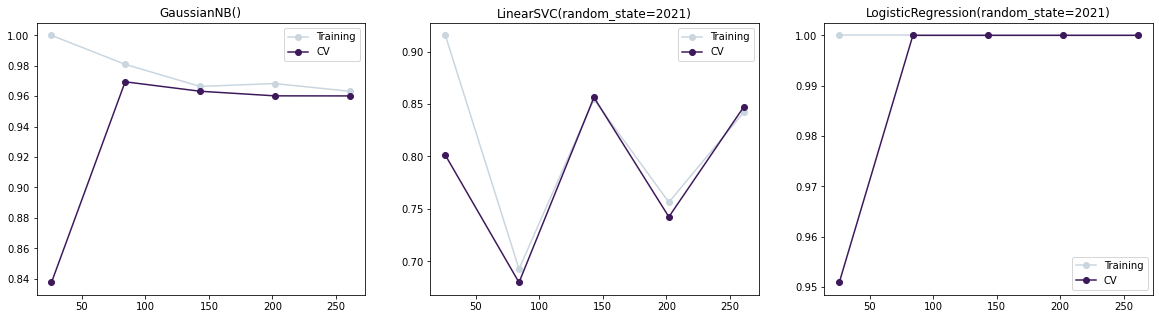

In [31]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
# Naive Bayes
nb = naive_bayes.GaussianNB()
# Linear SVM
lsvm = LinearSVC(random_state=2021)
# Logistic Regression
logit = LogisticRegression(random_state=2021)

models = [nb, lsvm, logit]
for i in range(3):
    train_sizes, train_score, valid_scores = learning_curve(models[i], X_table_train, y_table_train, cv=5)
    ax.flatten()[i].plot(train_sizes, np.mean(train_score, axis=1), 'o-', color=b4_color, label='Training')
    ax.flatten()[i].plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', color=t4_color, label='CV')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_title(f'{models[i]}')

### For clubstats_train

In [32]:
# For clubstats_train
# Naive Bayes
c_nb = naive_bayes.GaussianNB()

# Linear SVM
c_lsvm = LinearSVC(random_state=2021)

# Logistic Regression
c_logit = LogisticRegression(random_state=2021)

# Naive Bayes Training
c_nb.fit(X_club_train, y_club_train)
c_lsvm.fit(X_club_train, y_club_train)
c_logit.fit(X_club_train, y_club_train)

# Predictions on validation set
c_nb_preds = c_nb.predict(X_club_valid)
c_lsvm_preds = c_lsvm.predict(X_club_valid)
c_logit_preds = c_logit.predict(X_club_valid)

print(f'F1 Scores \n Naive Bayes: {f1_score(y_club_valid, c_nb_preds)} \n Linear SVM: {f1_score(y_club_valid, c_lsvm_preds)} \n Logitstic Regression: {f1_score(y_club_valid, c_logit_preds)}')

F1 Scores 
 Naive Bayes: 0.8636363636363636 
 Linear SVM: 0.3846153846153846 
 Logitstic Regression: 0.5


### Visualize the learning

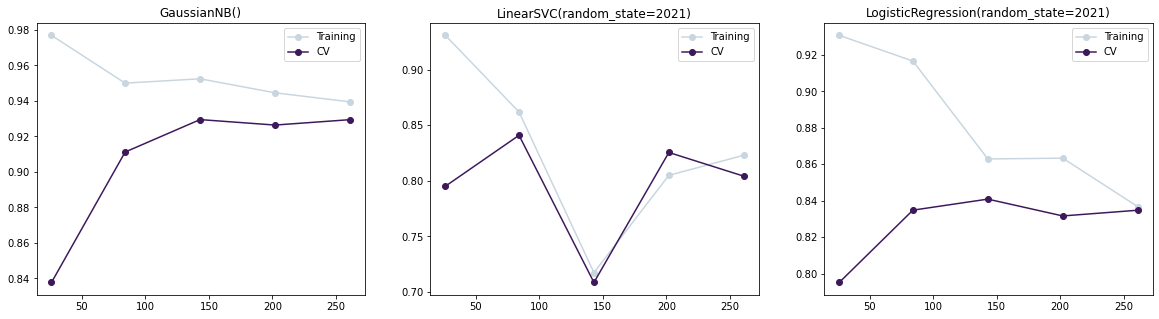

In [33]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
# Naive Bayes
nb = naive_bayes.GaussianNB()
# Linear SVM
lsvm = LinearSVC(random_state=2021)
# Logistic Regression
logit = LogisticRegression(random_state=2021)

models = [nb, lsvm, logit]
for i in range(3):
    train_sizes, train_score, valid_scores = learning_curve(models[i], X_club_train, y_club_train, cv=5)
    ax.flatten()[i].plot(train_sizes, np.mean(train_score, axis=1), 'o-', color=b4_color, label='Training')
    ax.flatten()[i].plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', color=t4_color, label='CV')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_title(f'{models[i]}')

### For tables_train & clubstats_train

In [58]:
tables_clubs = pd.concat([tables_train.drop('is_top4',axis=1), clubstats_train.drop('season', axis=1)], axis=1)
tables_clubs = tables_clubs.drop(tables_clubs[tables_clubs['season'] < 2006].index, axis=0)

In [59]:
# Split Train and Test set
X_tc_train, X_tc_test, y_tc_train, y_tc_test = train_test_split(tables_clubs.drop('is_top4', axis=1), tables_clubs['is_top4'], test_size=0.4, random_state=2021, stratify=tables_clubs['is_top4'])


# Split Test set for validation set
X_tc_valid, X_tc_test, y_tc_valid, y_tc_test = train_test_split(X_tc_test, y_tc_test, test_size=0.5, random_state=2021, stratify=y_tc_test)

In [60]:
# For clubstats_train
# Naive Bayes
tc_nb = naive_bayes.GaussianNB()

# Linear SVM
tc_lsvm = LinearSVC(random_state=2021)

# Logistic Regression
tc_logit = LogisticRegression(random_state=2021)

# Naive Bayes Training
tc_nb.fit(X_tc_train, y_tc_train)
tc_lsvm.fit(X_tc_train, y_tc_train)
tc_logit.fit(X_tc_train, y_tc_train)

# Predictions on validation set
tc_nb_preds = tc_nb.predict(X_tc_valid)
tc_lsvm_preds = tc_lsvm.predict(X_tc_valid)
tc_logit_preds = tc_logit.predict(X_tc_valid)

print(f'F1 Scores \n Naive Bayes: {f1_score(y_tc_valid, tc_nb_preds)} \n Linear SVM: {f1_score(y_tc_valid, tc_lsvm_preds)} \n Logitstic Regression: {f1_score(y_tc_valid, tc_logit_preds)}')

F1 Scores 
 Naive Bayes: 0.9166666666666666 
 Linear SVM: 0.8695652173913043 
 Logitstic Regression: 0.8695652173913043


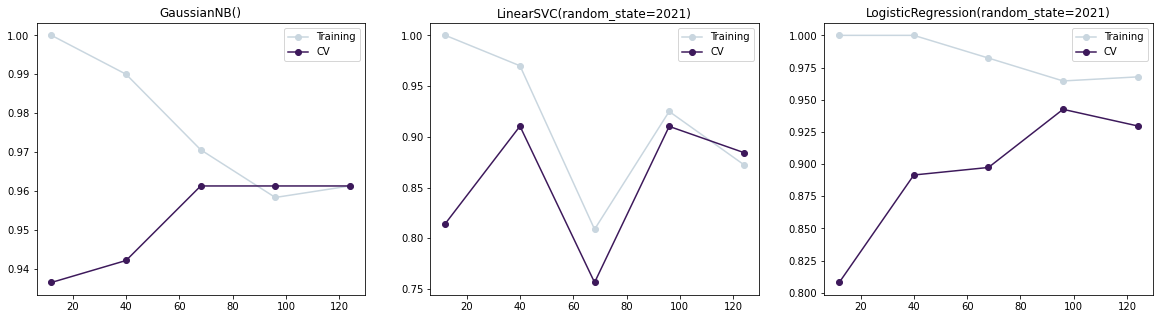

In [61]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
# Naive Bayes
nb = naive_bayes.GaussianNB()
# Linear SVM
lsvm = LinearSVC(random_state=2021)
# Logistic Regression
logit = LogisticRegression(random_state=2021)

models = [nb, lsvm, logit]
for i in range(3):
    train_sizes, train_score, valid_scores = learning_curve(models[i], X_tc_train, y_tc_train, cv=5)
    ax.flatten()[i].plot(train_sizes, np.mean(train_score, axis=1), 'o-', color=b4_color, label='Training')
    ax.flatten()[i].plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', color=t4_color, label='CV')
    ax.flatten()[i].legend()
    ax.flatten()[i].set_title(f'{models[i]}')

### Prediction on the test set

In [ ]:
table_X = tables_test.drop('is_top4', axis=1)
table_y = tables_test['is_top4']
club_X = clubstats_test.drop('is_top4', axis=1)
club_y = clubstats_test['is_top4']

In [ ]:
t_p = nb.predict(club_X)

In [ ]:
t_p

In [ ]:
f1_score(club_y, t_p)

## Limitations and others

In [ ]:
plt.bar(x=clubstats_train['is_top4'].value_counts().index, height=clubstats_train['is_top4'].value_counts().values)
plt.show()

print(f"True percentage of is_top4: {clubstats_train['is_top4'].value_counts()[1] / np.sum(clubstats_train['is_top4'].value_counts())}")

In [ ]:
plt.bar(x=tables_train['is_top4'].value_counts().index, height=tables_train['is_top4'].value_counts().values)
plt.show()

print(f"True percentage of is_top4 :{tables_train['is_top4'].value_counts()[1] / np.sum(tables_train['is_top4'].value_counts())}")